# Notebook to create smaller chunks (1024x1024) of the large scans

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
import os
from tqdm.notebook import tqdm
import cv2
import pandas as pd
import numpy as np
import json
import torch
import pickle
import torch.nn.functional as F
from random import randint

In [2]:
!pwd

/home/olli/Projects/Kaggle/Vesuvius/Notebooks


In [3]:
folder = '/home/olli/Projects/Kaggle/Vesuvius'
folder_data = os.path.join(folder, 'Data')
folder_preprocess = os.path.join(folder_data, 'Preprocessed')

# On each scan the letters were marked with bounding boxes

# Now use these to crop & resize the regions & save as final data

In [4]:
os.listdir(folder_preprocess)

['bboxes.json', 'images', 'Cropped_Regions']

In [5]:
path_bboxes = os.path.join(folder_preprocess, 'bboxes.json')

In [6]:
# load the json file with the bounding boxes
with open(path_bboxes, 'rb') as f:
    bboxes = json.load(f)

In [7]:
# number if labeled images (3 scans)
len(bboxes)

3

In [8]:
for scan in bboxes:
    name = scan['image'].split('.')[-2].split('-')[-1]
    print(f'Number of labeled bounding boxes from scan {name}: {len(scan["label"])}')

Number of labeled bounding boxes from scan inklabels_1: 28
Number of labeled bounding boxes from scan inklabels_2: 89
Number of labeled bounding boxes from scan inklabels_3: 20


# Plot all three scans marked with their bbox labels

In [9]:
bboxes[0].keys()

dict_keys(['image', 'id', 'label', 'annotator', 'annotation_id', 'created_at', 'updated_at', 'lead_time'])

In [10]:
bboxes[0]['image']

'/data/upload/1/1303012e-inklabels_1.png'

In [11]:
bboxes[0]['label'][0]

{'x': 19.95926680244399,
 'y': 18.26771653543307,
 'width': 16.293279022403258,
 'height': 11.338582677165354,
 'rotation': 0,
 'rectanglelabels': ['Letter'],
 'original_width': 6330,
 'original_height': 8181}

  0%|          | 0/3 [00:00<?, ?it/s]

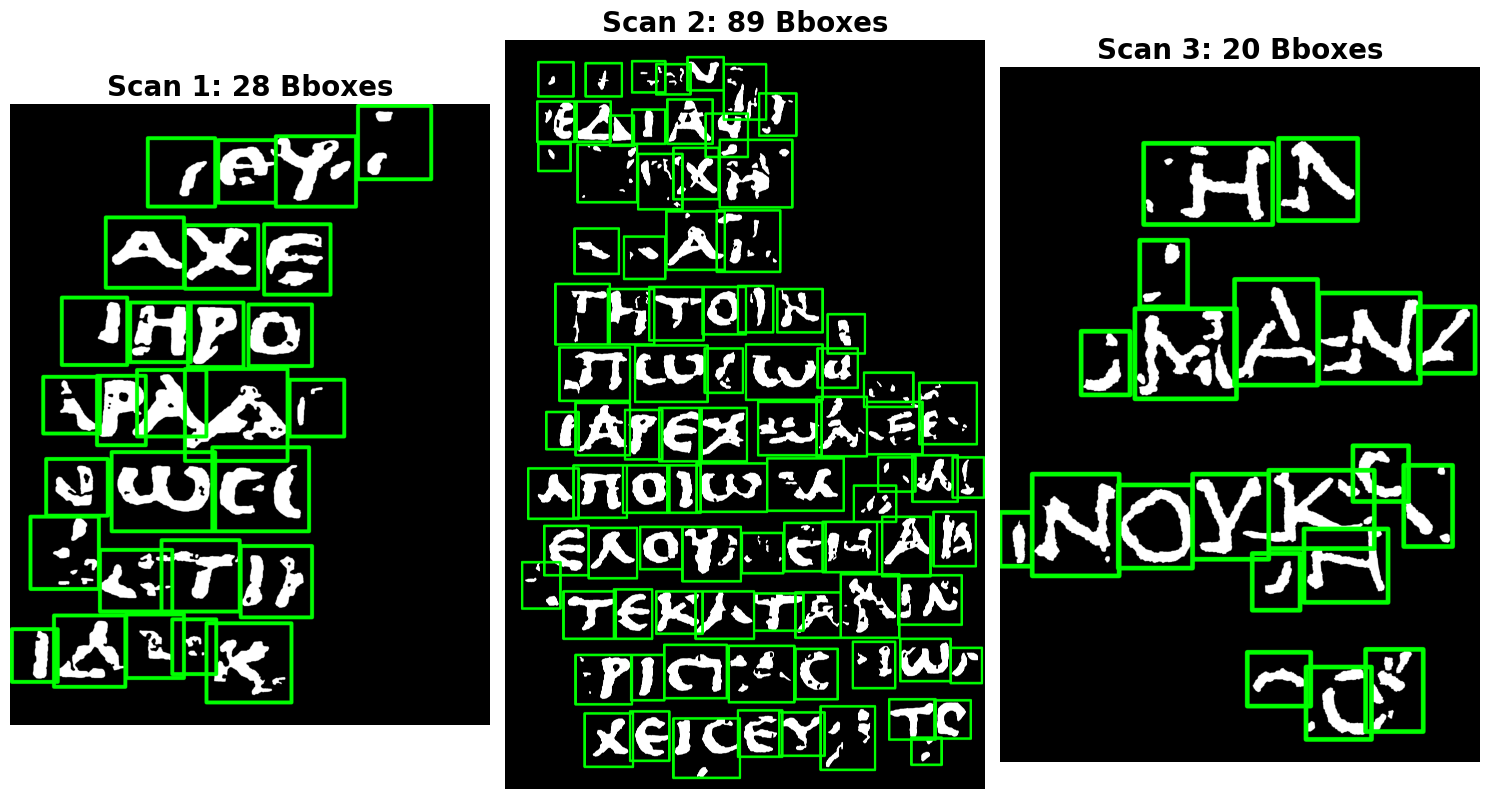

In [12]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 10))
for i in tqdm(range(3)):
    img_path = glob(folder_preprocess + f'/images/*inklabels_{str(i + 1)}.png')[0]
    img = cv2.imread(img_path)#, cv2.IMREAD_GRAYSCALE)  # need 3 channels for colored bbox
    bbox = bboxes[i]
    num_boxes = len(bbox['label'])
    # get the height and width to calculate the location of the bboxes from the json file
    height, width, _ = img.shape
    # loop over all labels and mark them in the scan with an rectangle of the correct size
    for label in bbox['label']:
        # all metrics in labels are in % of height/width
        start_x = int(label['x'] * width / 100)
        start_y = int(label['y'] * height / 100)
        end_x = int(start_x + label['width'] * width / 100)
        end_y = int(start_y + label['height'] * height / 100)

        # mark the bbox in the label
        img = cv2.rectangle(img, (start_x, start_y), (end_x, end_y), thickness=50, color=(0, 255, 0))
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(f'Scan {i + 1}: {num_boxes} Bboxes', fontsize=20, fontweight='bold')
    ax[i].axis('off')
    
fig.tight_layout()
fig.patch.set_facecolor('white')
fig.savefig(folder + '/Figures/Visualize_Bboxes.png', bbox_inches='tight')
plt.show()

# Now that the labels are loaded correct, create the data

In [13]:
'''We want to crop the bbox of the scan with a certain depth and the label and save it together.
   The depth should not be too deep since ink is only in the first layers.
   '''

def crop_boxes(depth=6):
    
    new_dir = 'Cropped_Regions'
    path_new_dir = os.path.join(folder_preprocess, new_dir)
    
    # create the data only once (if folder does not exist yet)
    if not os.path.exists(path_new_dir):
        os.makedirs(path_new_dir)
        
        for i in range(3):
            scan = i + 1  # 1, 2, 3

            path_scan = os.path.join(folder_data, 'train', str(scan))
            path_label = os.path.join(path_scan, 'inklabels.png')
            scans = glob(path_scan + '/surface_volume/*.tif')

            # sort scans to assign the top one depending on the depth
            scans.sort()
            scans = scans[:depth]

            label = cv2.imread(path_label, cv2.IMREAD_GRAYSCALE)

            height, width = label.shape
            
            # bboxes from the correct scan
            bbox = bboxes[i]

            # now first create an empty tensor with the correct shape and assign the scan
            tensor = torch.empty((height, width, depth))  

            # now assign each layer
            for ix, path_layer in enumerate(scans):
                layer = cv2.imread(path_layer, cv2.IMREAD_GRAYSCALE)
                tensor[:, :, ix] = torch.tensor(layer)  # assign in at the right place  (depth == ix)
            
            # now crop out all the bboxes from the scan with the correct number of layers
            for ix, box in tqdm(enumerate(bbox['label']), total=len(bbox['label'])):
                
                start_x = int(box['x'] * width / 100)
                start_y = int(box['y'] * height / 100)
                end_x = int(start_x + box['width'] * width / 100)
                end_y = int(start_y + box['height'] * height / 100)
                
                # crop out the correct region from the scan and the label
                X = tensor[start_y:end_y, start_x:end_x, :]  # full deptch since its the correct layers allready
                y = label[start_y:end_y, start_x:end_x]

                # reshape the tensors with a good interpolation
                X = cv2.resize(X.numpy(), dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC)
                y = cv2.resize(y, dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC)

                # now save them in a tuple with a unique name
                new_name = str(scan) + '_' + str(ix) + '.pickle'
                save_path = os.path.join(path_new_dir, new_name)

                save_obj = (X, y)

                with open(save_path, 'wb') as f:
                    pickle.dump(save_obj, f)

In [14]:
%%time
crop_boxes()

CPU times: user 89 µs, sys: 7 µs, total: 96 µs
Wall time: 76.1 µs


# Finally show some results to see if it worked

In [17]:
# show num random results

def show_some_results(num):
    files = glob(folder_preprocess + '/Cropped_Regions/*.pickle')
    
    # show num results
    for i in range(num):
        index = randint(0, len(files) - 1)
        
        scan, number = files[index].split('.')[-2].split('/')[-1].split('_')
        
        # load the file with the random index
        with open(files[index], 'rb') as f:
            file = pickle.load(f)
            
        X, y = file  # unpack it
        X = X[:, :, 0]  # just plot the first layer  
        
        fig, ax = plt.subplots(ncols=2, figsize=(10, 6))
        ax[0].imshow(X, cmap='gray')
        ax[1].imshow(y, cmap='gray')
        ax[0].axis('off')
        ax[1].axis('off')
        ax[0].set_title(f'Scan {scan} Number {number}', fontsize=15, fontweight='bold')
        ax[1].set_title(f'Label', fontsize=15, fontweight='bold')

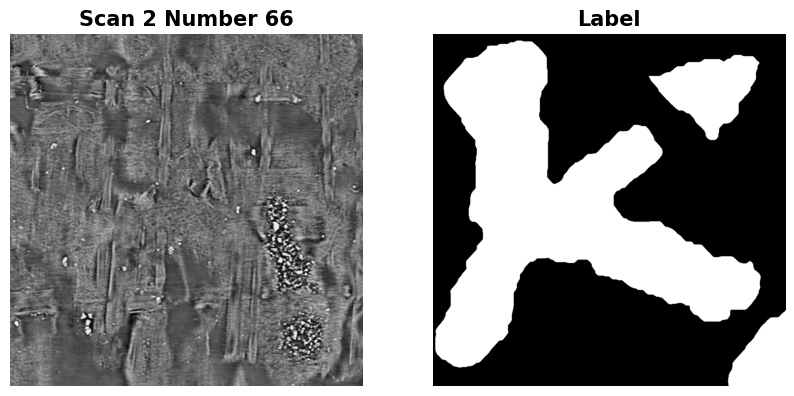

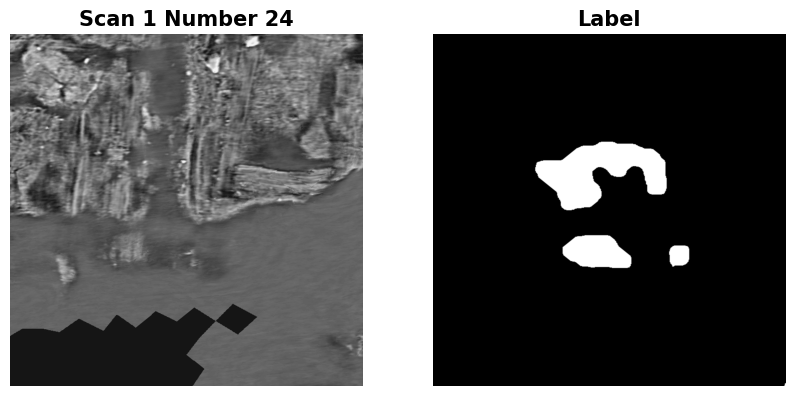

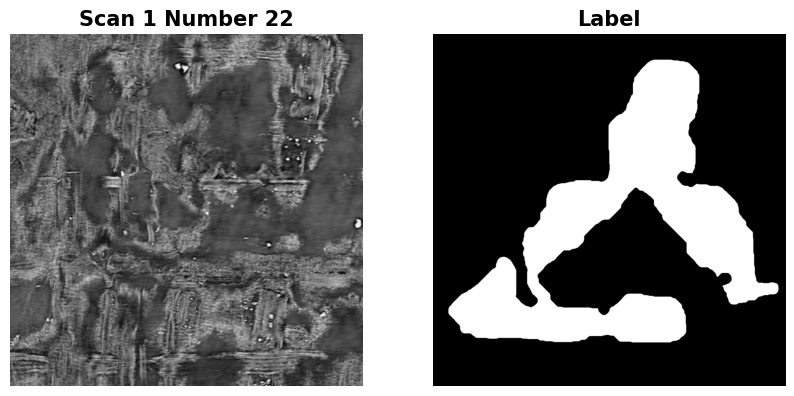

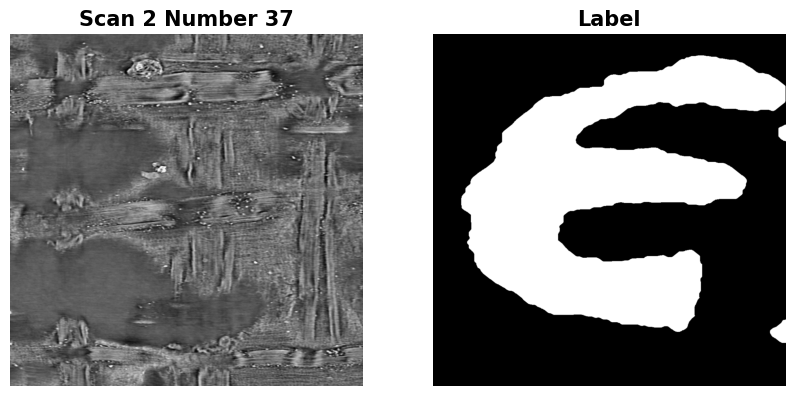

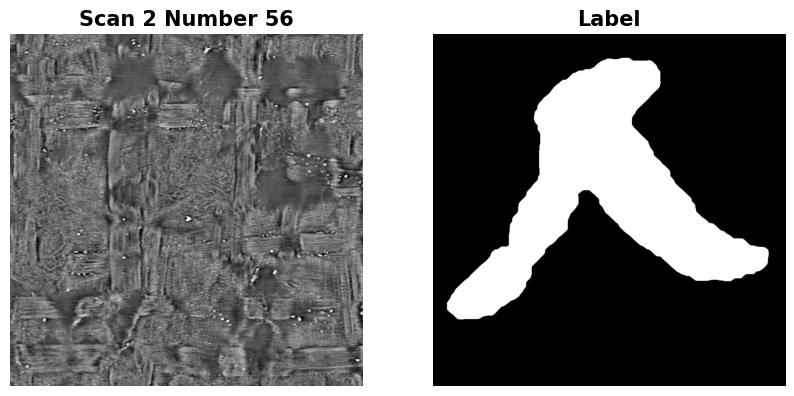

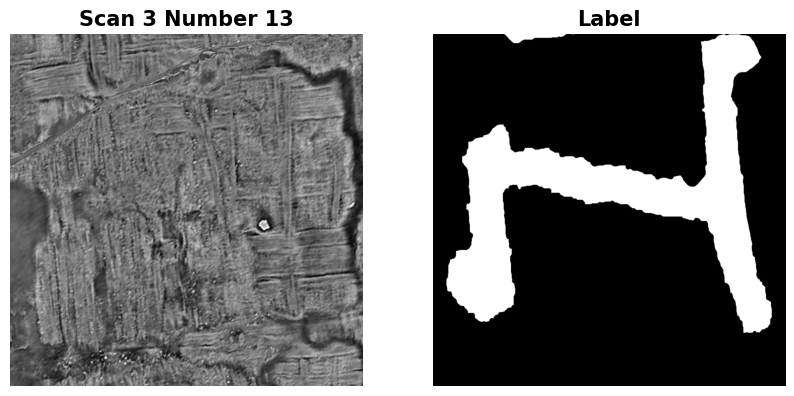

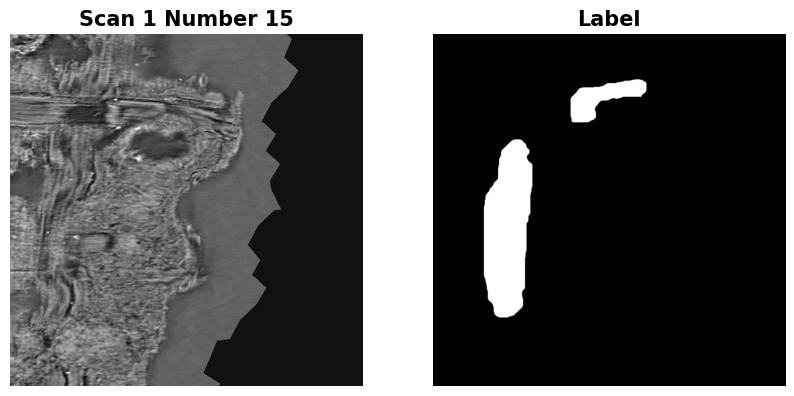

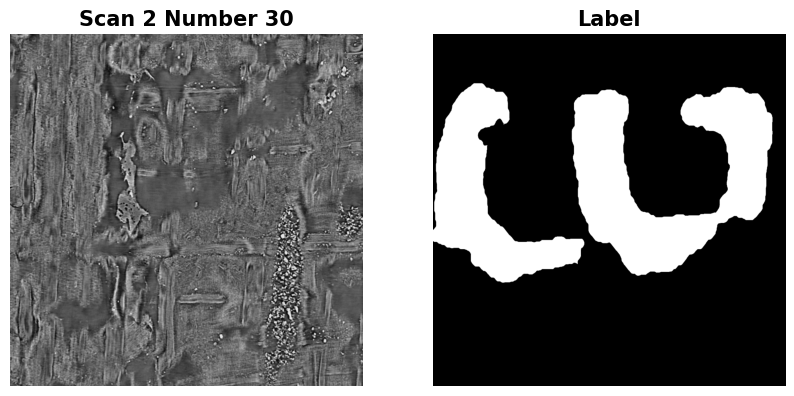

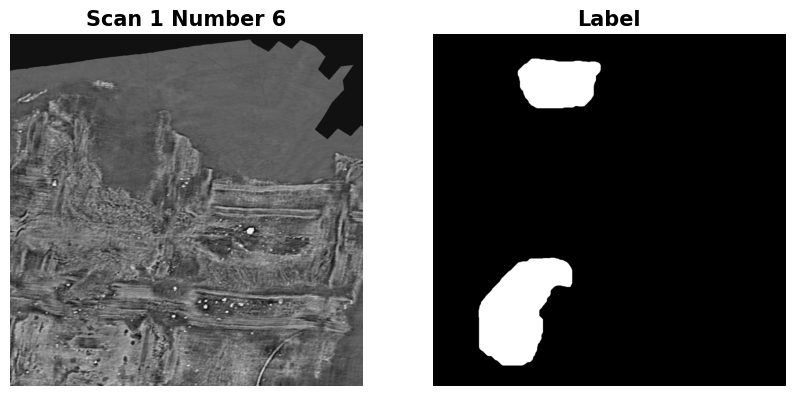

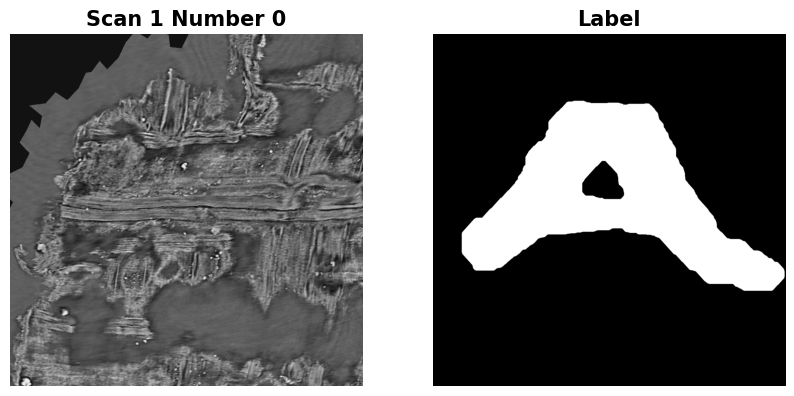

In [18]:
show_some_results(10)

The results look good and also show the difficulty of detecting ink on the scans (not detectable with human eyes)